In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
import keras
from keras import layers


import pandas as pd

import warnings
warnings.filterwarnings('ignore')

2024-07-11 18:41:28.222047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 18:41:28.222167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 18:41:28.508821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
train_a = pd.read_csv("/kaggle/input/numta/training-a.csv") 
train_a.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [5]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19702 entries, 0 to 19701
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   filename                19702 non-null  object
 1   original filename       19702 non-null  object
 2   scanid                  19702 non-null  int64 
 3   digit                   19702 non-null  int64 
 4   database name original  19702 non-null  object
 5   contributing team       19702 non-null  object
 6   database name           19702 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


In [6]:
len(os.listdir("/kaggle/input/numta/training-a"))

19702

In [7]:
train_a['digit'].unique()

array([5, 3, 1, 7, 0, 4, 9, 8, 2, 6])

In [8]:
img_size = 64
def read_image(image_path):
    img = tf.io.read_file(image_path) 
    img = tf.io.decode_png(img, 1) 
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.image.convert_image_dtype(img, tf.float32) / 255.0  
    return img

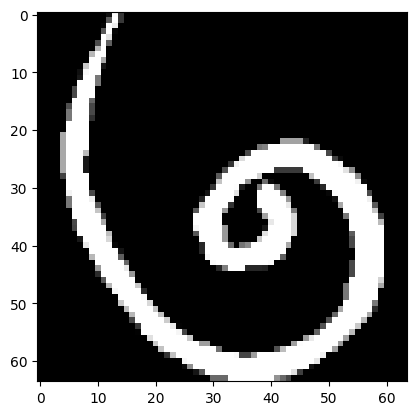

In [9]:
img = read_image("/kaggle/input/numta/training-e/e00083.png") 

plt.imshow(img, cmap='gray')

In [10]:
main_path = "/kaggle/input/numta"
def prepare_data():
    all_images_path = [] 
    all_labels = [] 
    
    csv_files = [os.path.join(main_path, x) for x in os.listdir(main_path) if x.endswith(".csv")]
    
    for csv_file in csv_files:
        data = pd.read_csv(csv_file) 
        image_names = data['filename'].values
        file_dir = data['database name'].values 
        labels = data['digit'] 
        
        for i in range(len(labels)):
            image_full_path = os.path.join(main_path, file_dir[i], image_names[i]) 
            all_images_path.append(image_full_path) 
            all_labels.append(labels[i]) 
    
    return np.array(all_images_path), np.array(all_labels)

In [11]:
all_images_path, all_labels = prepare_data()

In [12]:
#shuffling images and labels 
random_indexes = np.random.permutation(len(all_labels)) 

all_images_path = all_images_path[random_indexes] 
all_labels = all_labels[random_indexes] 

print(all_images_path[:5], all_labels[:5])


['/kaggle/input/numta/training-c/c06083.png'
 '/kaggle/input/numta/training-a/a07555.png'
 '/kaggle/input/numta/training-c/c10303.png'
 '/kaggle/input/numta/training-c/c10184.png'
 '/kaggle/input/numta/training-c/c19320.png'] [2 8 5 5 7]


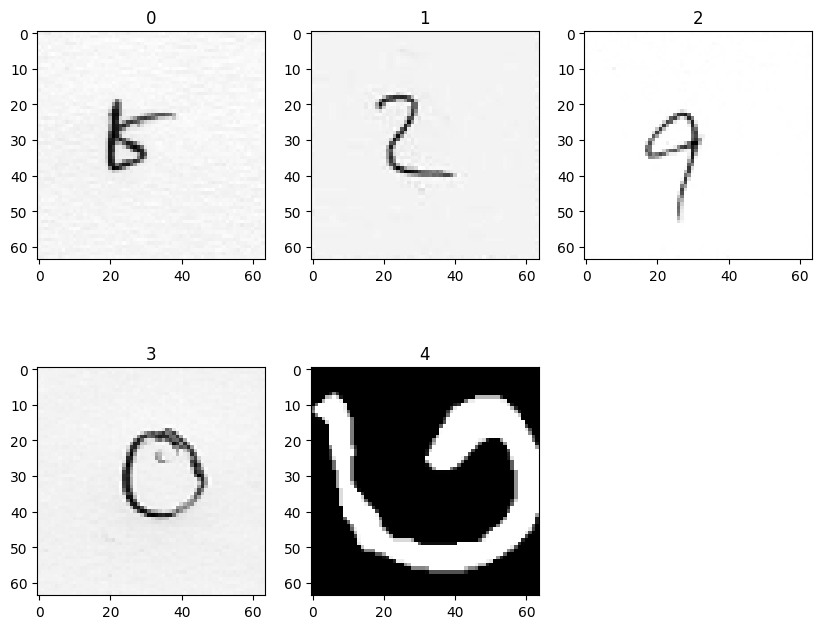

In [13]:

testing_images = [] 
testing_images.append(read_image("/kaggle/input/numta/training-a/a00029.png" ))
testing_images.append(read_image("/kaggle/input/numta/training-b/b00003.png"))
testing_images.append(read_image("/kaggle/input/numta/training-c/c00004.png"))
testing_images.append(read_image("/kaggle/input/numta/training-d/d00004.png"))
testing_images.append(read_image("/kaggle/input/numta/training-e/e00006.png"))


plt.figure(figsize=(10,8))
for i in range(5):
    plt.subplot(2,3,i+1) 
    plt.imshow(testing_images[i], cmap='gray') 
    plt.title(f"{i}")

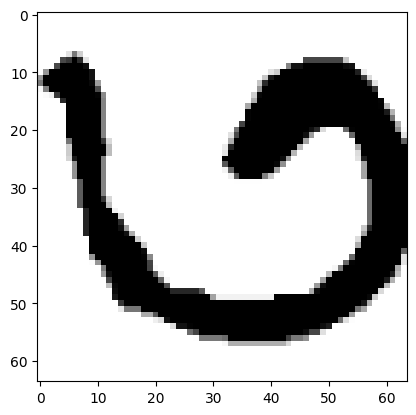

In [14]:
img = 1 - testing_images[4] 
plt.imshow(img, cmap='gray')

In [15]:
def is_background_white(image):
    
    img = tf.cast(image >= 0.5, tf.int32)
    
    no_of_1 = tf.reduce_sum(tf.cast(img ==1 , tf.int32))
    no_of_0 =  tf.reduce_sum(tf.cast(img ==0, tf.int32)) 
    
    if no_of_1 > no_of_0:
        return True 
    else:
        return False

is_background_white(testing_images[2])

True

In [16]:
batch_size = 32 
num_classes = 10

def process_ds(image_path, label):
    img = read_image(image_path)

    if is_background_white(img):
        img = 1 - img
    
    ohe_label = keras.utils.to_categorical(label, num_classes) 
    return img, ohe_label



def prepare_ds(image_paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels)) 
    ds = ds.map(process_ds) 
    ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE) 
    return ds

In [17]:
train_size = int(0.9 * len(all_labels))
val_size = int(0.05 * len(all_labels))

train_images = all_images_path[:train_size]
train_labels = all_labels[:train_size] 

val_images = all_images_path[train_size: train_size + val_size] 
val_labels = all_labels[train_size: train_size + val_size] 

test_images = all_images_path[train_size + val_size : ] 
test_labels = all_labels[train_size + val_size: ]


train_ds = prepare_ds(train_images, train_labels) 
val_ds = prepare_ds(val_images, val_labels) 
test_ds = prepare_ds(test_images, test_labels)

In [18]:
imgs, labels = next(iter(val_ds))

imgs.shape, labels.shape

(TensorShape([32, 64, 64, 1]), TensorShape([32, 10]))

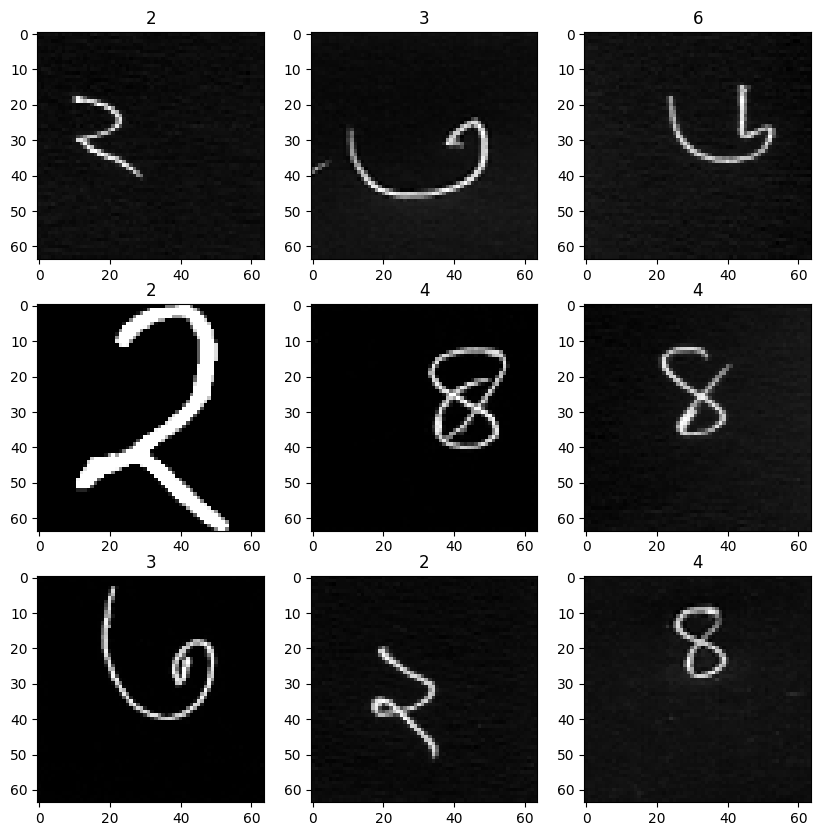

In [19]:
plt.figure(figsize=(10,10)) 

for i in range(9):
    plt.subplot(3,3,i+1) 
    image = imgs[i] 
    label = np.argmax(labels[i], axis=-1) 
    
    plt.imshow(image, cmap='gray') 
    plt.title(f"{label}")

In [20]:
def get_model(img_size, num_labels):
    inputs = layers.Input(shape=(img_size, img_size, 1)) 
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x) 
    x = layers.MaxPooling2D(pool_size=2)(x) 
    
    x = layers.Conv2D(64, kernel_size = 3, strides=1, padding='same', activation='relu')(x) 
    x = layers.BatchNormalization()(x) 
    x = layers.MaxPooling2D(pool_size=2)(x) 
    
    x = layers.Conv2D(128, kernel_size = 3, strides=1, padding='same', activation='relu')(x) 
    x = layers.BatchNormalization()(x) 
    x = layers.MaxPooling2D(pool_size=2)(x) 
    
    x = layers.Flatten()(x) 
    x = layers.Dense(64, activation='relu')(x) 
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(32, activation='relu')(x) 
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(num_labels, activation='softmax')(x) 
    
    model = keras.models.Model(inputs, x, name='bengali_digit_recognizer') 
    return model

In [21]:
model = get_model(img_size, num_classes)

model.summary()

Model: "bengali_digit_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,330 (2.37 MB)

 Trainable params: 619,882 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
model_file_path = "bengali_digit_recognizer.keras" 
model_checkpoint = keras.callbacks.ModelCheckpoint(model_file_path) 
model.compile(loss='mse', optimizer= 'adam', metrics=['accuracy']) 


history = model.fit(train_ds, validation_data = val_ds, epochs=30, callbacks=[model_checkpoint])

Epoch 1/30
   6/2027 ━━━━━━━━━━━━━━━━━━━━ 1:08 34ms/step - accuracy: 0.1253 - loss: 0.1202

I0000 00:00:1720723365.725924     178 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720723365.749812     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2027/2027 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1507 - loss: 0.1070

W0000 00:00:1720723487.065283     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720723487.914836     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2027/2027 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - accuracy: 0.1507 - loss: 0.1070 - val_accuracy: 0.4803 - val_loss: 0.0627
Epoch 2/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.3834 - loss: 0.0672 - val_accuracy: 0.5611 - val_loss: 0.0513
Epoch 3/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 95s 47ms/step - accuracy: 0.4728 - loss: 0.0586 - val_accuracy: 0.7066 - val_loss: 0.0410
Epoch 4/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.5667 - loss: 0.0509 - val_accuracy: 0.7851 - val_loss: 0.0307
Epoch 5/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.5923 - loss: 0.0480 - val_accuracy: 0.8226 - val_loss: 0.0262
Epoch 6/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - accuracy: 0.6106 - loss: 0.0457 - val_accuracy: 0.8184 - val_loss: 0.0264
Epoch 7/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.6435 - loss: 0.0420 - val_accuracy: 0.8126 - val_loss: 0.0257
Epoch 8/30
2027/2027 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.6835 - loss: 0.0

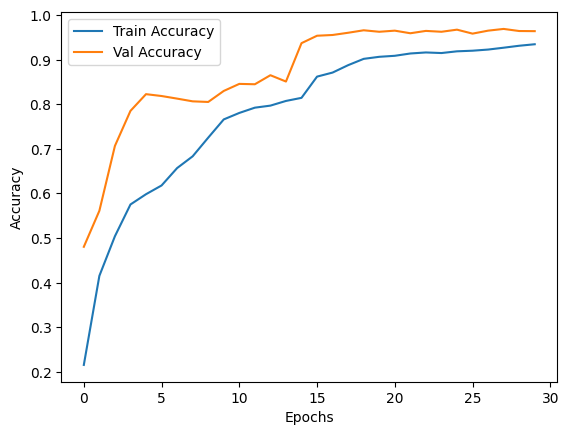

In [29]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Val Accuracy"])

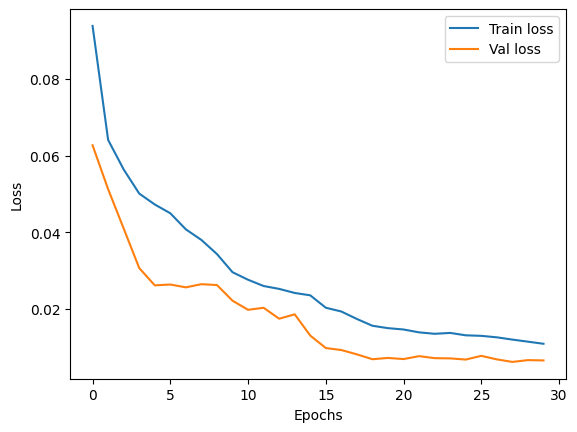

In [30]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.xlabel("Epochs") 
plt.ylabel("Loss")
plt.legend(['Train loss', 'Val loss']) 


In [32]:
#Inference 

images, labels = next(iter(test_ds))

preds = model.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


W0000 00:00:1720725273.371284     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


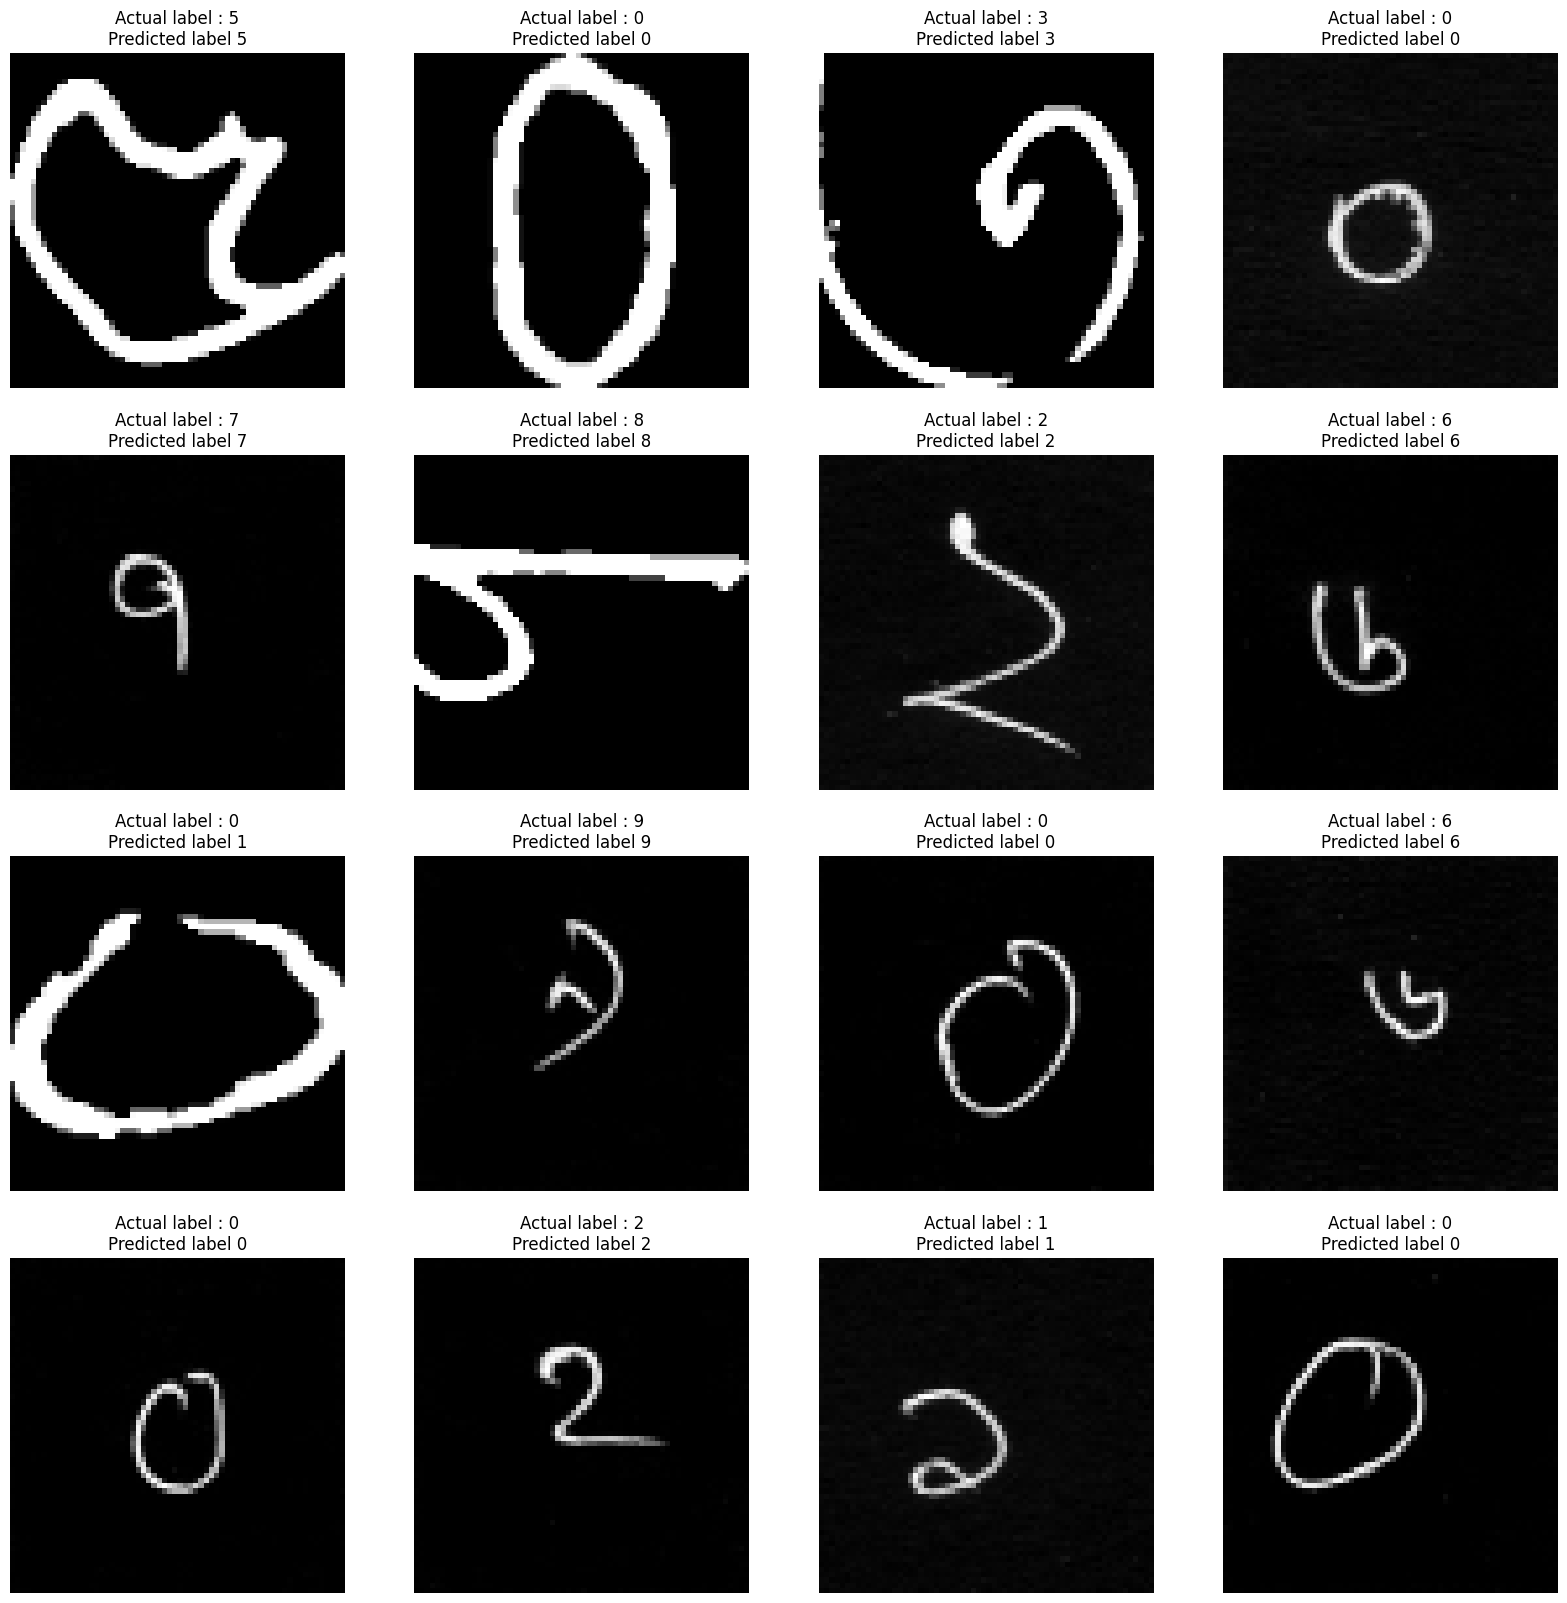

In [39]:
prediction = np.argmax(preds, axis=-1)
label = np.argmax(labels, axis=-1)

plt.figure(figsize=(20,20)) 

for i in range(16):
    plt.subplot(4,4,i+1) 
    plt.imshow(images[i], cmap='gray') 
    plt.title(f"Actual label : {label[i]}\nPredicted label {prediction[i]}")
    plt.axis('off')
    
plt.show()